### Import Libraries

In [1]:
import os, re, math, json, shutil, pprint, datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-rc1


### Cloud project setup and colab authentiation

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!gcloud config set project srgan-deploy

Updated property [core/project].


In [41]:
!gcloud ai-platform models list

NAME              DEFAULT_VERSION_NAME
srgan_mse         version_1
srgan_perpix      version_1
srgan_perpix_gpu  version_1


In [0]:
# !gcloud components update

### Configuration

In [0]:
REGION = "us-central1"
BUCKET_NAME = "srgan-deploy-aiplatform-mse"
PROJECT = "srgan-deploy"


In [0]:
MODEL_VERSION = "version_1" #@param {type:"string"}

MODEL_NAME = "srgan_mse"
### Saved model path
MODEL_BINARIES = "gs://srgan-deploy-aiplatform-mse/export_saved_model/gan_estimator_export/1585529345/"
NEW_MODEL = True #@param {type:"boolean"}


### Create Bucket

In [0]:
# !gsutil mb -l {REGION} gs://{BUCKET_NAME}

In [0]:
# !gsutil cp -r ./dir gs://{BUCKET_NAME}

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [0]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions={REGION} 
  # !gcloud ml-engine models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

Created ml engine model [projects/srgan-deploy/models/srgan_perpix].


In [0]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/ai-platform/models/"

!gcloud ai-platform versions create {MODEL_VERSION} \
    --model={MODEL_NAME} \
    --origin={MODEL_BINARIES} \
    --project={PROJECT} \
    --runtime-version=1.15 \
    --python-version=3.7

# !gcloud ml-engine versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.10

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/ai-platform/models/


In [0]:
# gcloud beta ai-platform versions create version_name \
#   --model model_name \
#   --origin gs://model-directory-uri \
#   --runtime-version 2.1 \
#   --python-version 3.7 \
#   --framework tensorflow \
#   --machine-type n1-standard-4 \
#   --accelerator count=1,type=nvidia-tesla-t4 \
#   --config config.yaml

### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [0]:
# !pip install tensorflow-gan

In [9]:

import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import matplotlib.pyplot as plt
import numpy as np

In [10]:
predict_ds = tfds.load(name='lfw' , split='train' )

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteNMKCI4/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [11]:
predict_ds_2 = predict_ds.map(lambda features : features['image'] )
predict_ds_2

<DatasetV1Adapter shapes: (250, 250, 3), types: tf.uint8>

In [12]:
predict_ds_batch = predict_ds_2.batch(1, drop_remainder=True)
predict_ds_batch

<DatasetV1Adapter shapes: (1, 250, 250, 3), types: tf.uint8>

Low resolution images prediction batch 


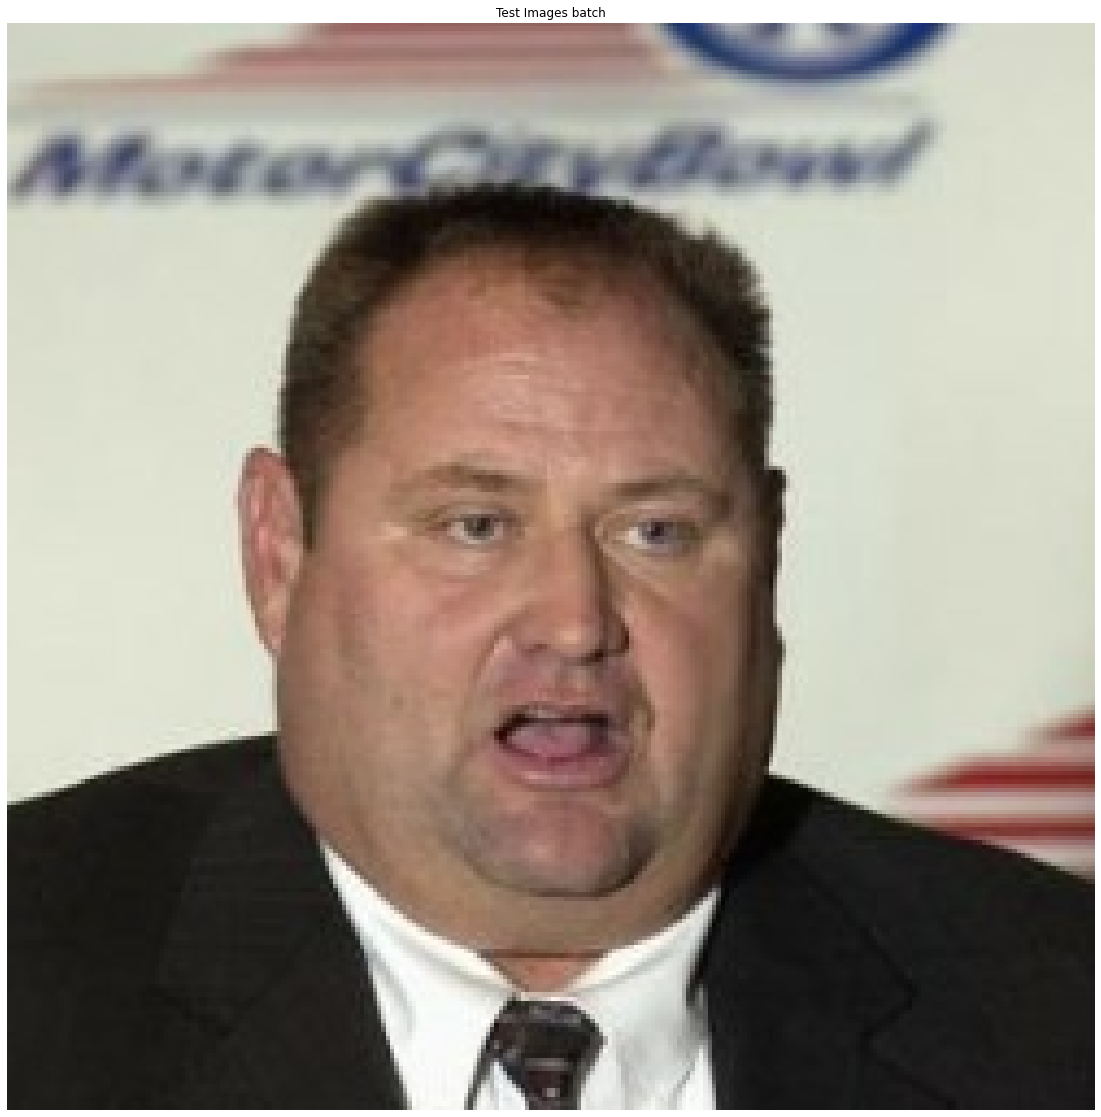

Test images size : (1, 250, 250, 3) 


In [13]:
test_imgs = next(tfds.as_numpy(predict_ds_batch))
test_imgs = test_imgs/255.0

test_imgs_grid = tfgan.eval.python_image_grid(test_imgs , grid_shape=(1, 1))
print('Low resolution images prediction batch ')
plt.figure(figsize=(20,20))
plt.axis('off')
plt.title('Test Images batch')
plt.imshow(np.squeeze(test_imgs_grid))
plt.show()

print("Test images size : {} " .format(test_imgs.shape))

In [0]:

with open("images.json", "w") as file_name:
  for img in test_imgs:
    # the format for ML Engine online predictions is: one JSON object per line
    input_data = json.dumps({"feature": img.tolist()})  
    file_name.write(input_data+'\n')

In [15]:
### Sanity check before sending the request to the AI-PLATFORM

with open("images.json") as f2:
  file_contents = json.load(f2)

file_contents_list = file_contents['feature']

file_contents_list_array = np.array(file_contents_list)
file_contents_list_array.shape

(250, 250, 3)

In [0]:
# !gsutil cp images.json gs://{BUCKET_NAME}/test/images.json

#### Online predictions

In [0]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
# predictions = !gcloud ml-engine predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}

predictions = !gcloud ai-platform predict --project={PROJECT} --model={MODEL_NAME} --version {MODEL_VERSION}  --json-instances images.json


In [0]:
predictions

['\x1bERROR:\x1b (gcloud.ai-platform.predict) HTTP request failed. Response: {',
 '  "error": {',
 '    "code": 400,',
 '    "message": "Request payload size exceeds the limit: 1572864 bytes.",',
 '    "status": "INVALID_ARGUMENT"',
 '  }',
 '}',
 '']

In [0]:

predictions = np.array([int(p.split('[')[0]) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
display_top_unrecognized(digits, predictions, labels, N, 100//N)

#### BATCH PREDICTION

In [0]:
# send the json to google cloud storage

### First remove previous file
# !gsutil rm gs://{BUCKET_NAME}/test/images.json

### Send json to google cloud bucket

# !gsutil cp images.json gs://{BUCKET_NAME}/test/images.json



In [0]:
# Set the  job name, input and output paths

JOB_NAME= "batch_prediction_mse1"

INPUT_JSON_PATH = "gs://" + str(BUCKET_NAME) + "/test/images.json"

OUTPUT_PATH= "gs://" + str(BUCKET_NAME) + "/" + str(JOB_NAME)

In [22]:
print(INPUT_JSON_PATH)
print(OUTPUT_PATH)

gs://srgan-deploy-aiplatform-mse/test/images.json
gs://srgan-deploy-aiplatform-mse/batch_prediction_mse1


In [23]:
## SUBMIT THE BATCH PREDICTION

!gcloud ai-platform jobs submit prediction {JOB_NAME} \
    --model {MODEL_NAME} \
    --version {MODEL_VERSION} \
    --data-format text \
    --region {REGION} \
    --input-paths {INPUT_JSON_PATH} \
    --output-path {OUTPUT_PATH}/predictions

Job [batch_prediction_mse1] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe batch_prediction_mse1

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs batch_prediction_mse1
jobId: batch_prediction_mse1
state: QUEUED


In [24]:
## To see the job description

!gcloud ai-platform jobs describe {JOB_NAME}

createTime: '2020-03-30T01:19:26Z'
etag: q7-pH0SUPZE=
jobId: batch_prediction_mse1
predictionInput:
  dataFormat: JSON
  inputPaths:
  - gs://srgan-deploy-aiplatform-mse/test/images.json
  outputPath: gs://srgan-deploy-aiplatform-mse/batch_prediction_mse1/predictions
  region: us-central1
  runtimeVersion: '1.15'
  versionName: projects/srgan-deploy/models/srgan_mse/versions/version_1
predictionOutput:
  outputPath: gs://srgan-deploy-aiplatform-mse/batch_prediction_mse1/predictions
startTime: '2020-03-30T01:19:27Z'
state: RUNNING

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/batch_prediction_mse1?project=srgan-deploy

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fbatch_prediction_mse1&project=srgan-deploy


In [0]:
# To see the logs of submitted job

# !gcloud ai-platform jobs stream-logs {JOB_NAME}

In [0]:
# To look at the results

# !gsutil cat {OUTPUT_PATH}/predictions/prediction.results-00000-of-00001

In [0]:
# !mkdir -p ./tmp_folder/{JOB_NAME}/

In [28]:
!gsutil cp -r {OUTPUT_PATH}/predictions ./tmp_folder/{JOB_NAME}/

Copying gs://srgan-deploy-aiplatform-mse/batch_prediction_mse1/predictions/prediction.errors_stats-00000-of-00001...
Copying gs://srgan-deploy-aiplatform-mse/batch_prediction_mse1/predictions/prediction.results-00000-of-00001...
- [2 files][ 60.9 MiB/ 60.9 MiB]                                                
Operation completed over 2 objects/60.9 MiB.                                     


In [29]:
!ls -r ./tmp_folder/{JOB_NAME}/predictions/

prediction.results-00000-of-00001  prediction.errors_stats-00000-of-00001


In [0]:
# !pip install ijson

In [0]:
import json
import pandas as pd
import ijson

In [0]:
json_output_file = "./tmp_folder/" + str(JOB_NAME) + "/predictions/prediction.results-00000-of-00001"

# with open("./tmp_folder/predictions/prediction.results-00000-of-00001") as f:
#   prediction = json.load(f)



In [0]:
data = []
with open(json_output_file, 'r') as f:
    objects = ijson.items(f, 'output')
    for row in objects:
            data.append(row)

In [0]:
data[0]

In [38]:
super_resolution_images = np.array(data).astype(float)
# super_resolution_images = np.expand_dims(super_resolution_images, axis = 0)
super_resolution_images.shape

(1, 1000, 1000, 3)

In [0]:
# tf.data.Dataset.from_tensor_slices(super_resolution_images ,)

Super resolution images of test images 


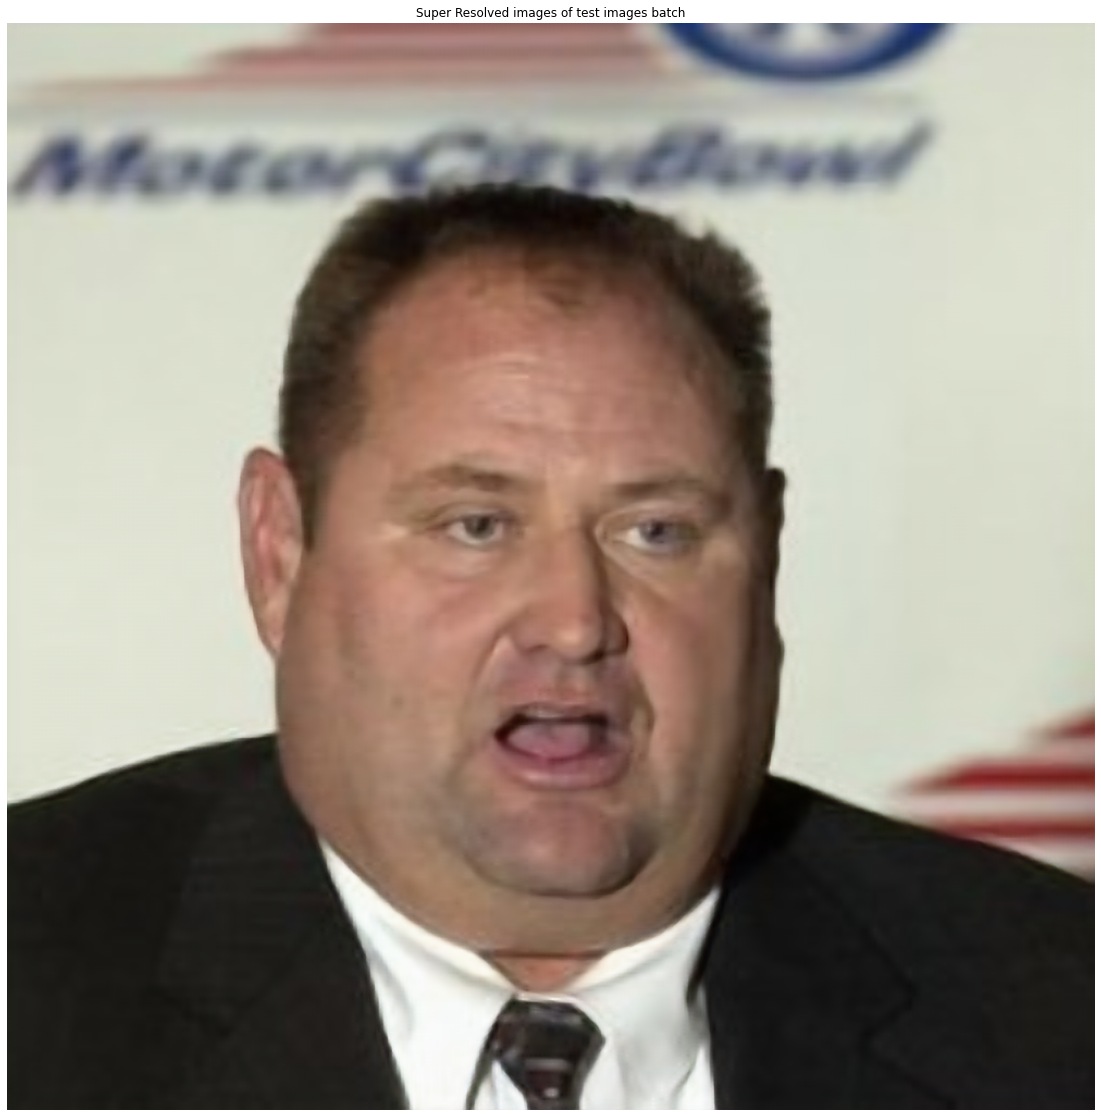

Super resolved images size : (1000, 1000, 3) 


In [40]:
pred_imgs_grid = tfgan.eval.python_image_grid( (super_resolution_images + 1.0)/2.0 , grid_shape=(1, 1))
print('Super resolution images of test images ')
plt.figure(figsize=(20,20))
plt.axis('off')
plt.title('Super Resolved images of test images batch')
plt.imshow(np.squeeze(pred_imgs_grid))
plt.show()

print("Super resolved images size : {} " .format(pred_imgs_grid.shape))